In [ ]:
!pip install facenet_pytorch --no-deps


In [ ]:
import shutil
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from facenet_pytorch import MTCNN
from PIL import Image
from torchvision.utils import make_grid

We'll also print out the version numbers for our libraries, including Python. This way anyone who reviews our work knows exactly what software we used in case they want to reproduce our analysis.

In [ ]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("PIL version : ", PIL.__version__)

Platform: linux
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
---
torch version :  2.6.0+cu124
torchvision version :  0.21.0+cu124
PIL version :  11.1.0


Let's also make use of GPUs, so the device should be `cuda`.

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### Initializing a MTCNN model

We'll perform face detection using a MTCNN network from `facenet_pytorch` library. This model is able to simultaneously propose bounding boxes of faces, determine detection probabilities, and detect facial landmarks like eyes, nose and mouth.

Let's start by initializing the model. Here are a couple of arguments we get to set:
- `device`: The device on which to run the model.
- `keep_all`: A boolean determining if all detected faces are returned or not.
- `min_face_size`: Minimum face size (in pixels) to search for in the image.
- `post_process`: A boolean determining if we want image standardization of detected faces. This is advised before proceeding with face recognition models, but if we want face images that are returned to us to look normal to the human eye, we can set `post_process=False`.


**Task 4.3.1:** Initialize a MTCNN model. Make sure to use a GPU, keep all detected faces and set minimum face size to search for to be 60.

In [ ]:
MTCNN?

In [ ]:
mtcnn = MTCNN(device=device, keep_all=True, min_face_size=60, post_process=False)

print(mtcnn)

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

Now let's get an image that we'll work with. In the previous lesson, we extracted some frames from the video interview with Mary Kom. Those images are in directory `project4`. In there we created a subdirectory `data` within which we have the `extracted_frames` subdirectory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Task 4.3.2:** Create a variable for the current working directory using `pathlib` syntax.

In [ ]:
curr_work_dir = Path.cwd()

print(curr_work_dir)

/content


**Task 4.3.3:** Create an absolute path for the `extracted_frames` directory using the `pathlib` syntax.

In [ ]:
from pathlib import Path

# Define the absolute path
extracted_frames_dir = Path("/content/drive/My Drive/Celebrity Sightings in India/videos/extracted_frames")

# Print the absolute path
print(extracted_frames_dir)


/content/drive/My Drive/Celebrity Sightings in India/videos/extracted_frames


**Task 4.3.4:** Create a file path to the sample image we'll be working with. The image is in the `extracted_frames` directory.

In [ ]:
from PIL import Image


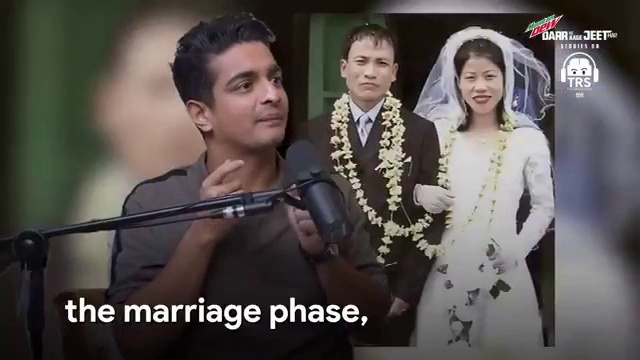

In [ ]:
sample_image_filename = "frame_320.jpg"
sample_image_path = extracted_frames_dir / sample_image_filename

sample_image = Image.open(sample_image_path)
sample_image


### Bounding Boxes of Detected Faces

If we want to detect faces and obtain their bounding boxes, we need to use the `detect` method on the MTCNN model and pass in the sample image. This returns both the bounding boxes of detected faces as well as the predicted probability that the object in a given bounding box is indeed a face.

**Task 4.3.5:** Use the `detect` method on the MTCNN model we initialized in one of the previous tasks. Make sure to pass in the `sample_image`.

In [ ]:
boxes, probs = mtcnn.detect(sample_image)

print("boxes type:", type(boxes))
print("probs type:", type(probs))

boxes type: <class 'numpy.ndarray'>
probs type: <class 'numpy.ndarray'>


Great! We now have two arrays. Array `boxes` contains the bounding boxes of the detected faces and `probs` contains the probabilities.

Let's look at the `boxes` array first.

In [ ]:
print(boxes)
print(boxes.shape)

[[210.06777954101562 46.35161209106445 285.5747985839844
  146.42161560058594]
 [346.06201171875 39.4800910949707 393.2386474609375 99.77130889892578]
 [459.1596374511719 56.59994888305664 503.3746032714844
  111.34190368652344]]
(3, 4)


**Task 4.3.6:** Using `boxes`, compute how many faces were detected in the sample image.

In [ ]:
number_of_detected_faces = len(boxes)

print(number_of_detected_faces)

3


If we again look at the image we're working with, we can indeed see three faces. We're on the right path!

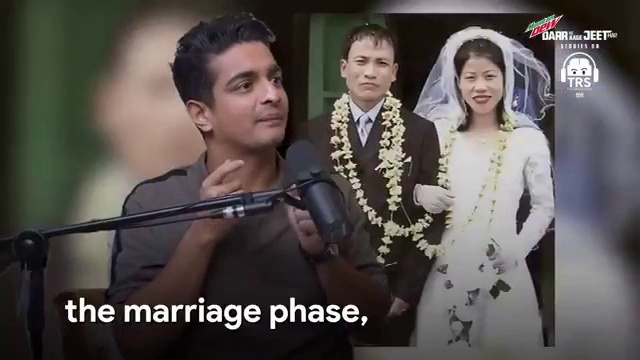

In [ ]:
sample_image

**Task 4.3.7:** Using `probs`, determine for how many of the faces detected did the model predict with at least 99% probability that it's a face.

In [ ]:
num_faces = len(probs[probs > 0.99])

print(num_faces)

3


Looks like the model is very certain that all of the detected faces are indeed faces!

Now let's plot the bounding boxes together with the sample image.

**Task 4.3.8:** To iterate over all of the bounding boxes and plot them on top of the sample image.

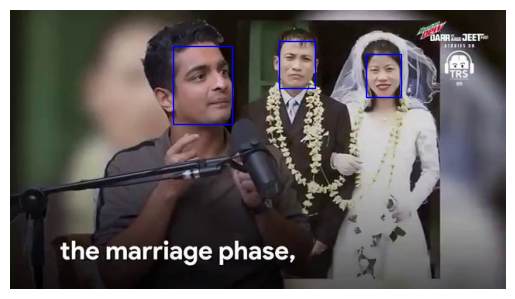

In [ ]:
fig, ax = plt.subplots()
ax.imshow(sample_image)

for box in boxes:
    rect = plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="blue"
    )
    ax.add_patch(rect)
plt.axis("off");

### __Extracting Facial Landmarks.__

MTCNN not only detects faces but can also mark facial landmarks such as eyes, nose, and mouth in each detected face.

The way to obtain the facial landmarks together with bounding boxes and probabilities is to again use the `detect` method on the MTCNN model. But this time together with the sample image, we need to pass in `landmarks=True`.

**Task 4.3.9:** Use the `detect` method on the MTCNN model such that we'll get bounding boxes, probabilities and facial landmarks returned.

In [ ]:
boxes, probs, landmarks = mtcnn.detect(sample_image, landmarks=True)

print("boxes type:", type(boxes))
print("probs type:", type(probs))
print("landmarks type:", type(landmarks))

boxes type: <class 'numpy.ndarray'>
probs type: <class 'numpy.ndarray'>
landmarks type: <class 'numpy.ndarray'>


The facial landmarks detected by the model on each face are:
- left eye,
- right eye,
- nose,
- left mouth corner,
- right mouth corner.

Let's make sure that the shape of the landmarks array matches what we'd expect given that six faces were detected.

**Task 4.3.10:** Print the shape of the landmarks array returned by the model.

In [ ]:
print(landmarks.shape)

(3, 5, 2)


Great! We have 3 faces detected and on each face, we have 5 facial landmarks and 2 coordinates locating each landmark.

**Task 4.3.11:** Fill in the missing code to plot the bounding boxes as well as the facial landmarks on top of the sample image. We recommend using `zip` on `boxes` and `landmarks` in the `for` loop that you need to fill in.

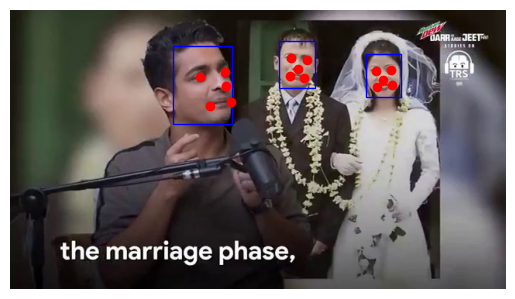

In [ ]:
fig, ax = plt.subplots()
ax.imshow(sample_image)

for box, landmark in zip(boxes, landmarks):
    rect = plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="blue"
    )
    ax.add_patch(rect)
    for point in landmark:
        ax.plot(point[0], point[1], marker="o", color="red")
plt.axis("off");

### __Cropping out Detected Faces.__

If we wanted to proceed with further face analysis like for example perform face recognition, it's a good idea to crop out the detected faces. That way further analysis can focus only on the relevant parts of the image.

So let's learn how we can crop out the detected faces!

In order to get the PyTorch tensors of the detected faces instead of the bounding boxes, we need to call the MTCNN object directly and just pass in the image we're working with.

**Task 4.3.12:** Use the MTCNN model that we initialized in the first task and pass it the `sample_image`.

In [ ]:
faces = mtcnn(sample_image)

print(faces.shape)

torch.Size([3, 3, 160, 160])


Looks like this returned three small images, each with 3 color channels and 160 width and 160 height. Let's plot these 3 images!

**Task 4.3.13:** Create a grid of these three images by using `make_grid` from `torchvision.utils` and passing in `faces`. Use `nrow=3` so we'll have all 3 images in one row.

In [ ]:
Grid = make_grid(faces, nrow=3)

print(Grid.shape)

torch.Size([3, 164, 488])


Now let's plot the grid of images!

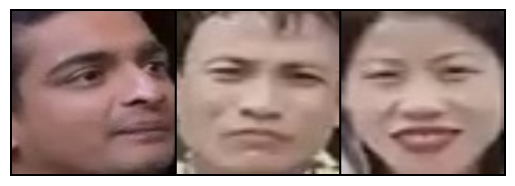

In [ ]:
plt.imshow(Grid.permute(1, 2, 0).int())
plt.axis("off");

We obtained the cropped faces that were detected.

**Task 4.3.14:** Make a directory into which we'll put the selected images. Make sure you do it such that no error is raised even if the directory already exists.

In [ ]:
images_dir = Path("/content/drive/My Drive/Celebrity Sightings in India/videos/images")
images_dir.mkdir(exist_ok=True)


**Task 4.3.15:** Make a subdirectory in the `images` directory and call it `mary_kom`. Again make sure you do it such that no error is raised even if the directory already exists.

In [ ]:
mary_kom_dir = images_dir / "mary_kom"

# Now Create `mary_kom` directory
mary_kom_dir.mkdir(exist_ok=True)

The director just created will be the directory into which we'll put the selected images.

Let's make a list of frames that we want to use.

In [ ]:
mary_kom_imgs = [
    "frame_80.jpg",
    "frame_115.jpg",
    "frame_120.jpg",
    "frame_125.jpg",
    "frame_135.jpg",
]

**Task 4.3.16:** Iterate over `mary_kom_imgs` list of image filenames and create a list of absolute paths to each image using `pathlib` syntax. Remember that the images are in the `extracted_frames` directory.

In [ ]:
mary_kom_img_paths = [extracted_frames_dir / i for i in mary_kom_imgs]

print("Number of images we'll use:", len(mary_kom_img_paths))

Number of images we'll use: 5


Before we copy these images over to `mary_kom` directory, let's just look at them.

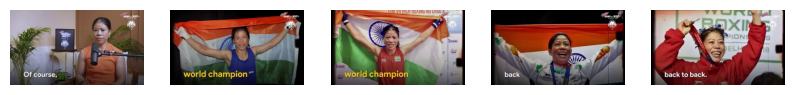

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(10, 8))

for i, ax in enumerate(axs):
    ax.imshow(Image.open(mary_kom_img_paths[i]))
    ax.axis("off")

**Task 4.3.17:** Iterate over `mary_kom_img_paths` in order to copy these selected images into `mary_kom` directory.

In [ ]:
for image_path in mary_kom_img_paths:
    shutil.copy(image_path, mary_kom_dir)

In [ ]:
print("Number of files in mary_kom directory:", len(list(mary_kom_dir.iterdir())))

Number of files in mary_kom directory: 5


We'll also get some images of the interviewer, so we'll have more than one face we can potentially identify. We'll call that directory `ranveer`, since that's the interviewer's first name.

**Task 4.3.18:** Make a subdirectory in the `images` directory and call it `ranveer`. Again make sure you do it such that no error is raised even if the directory already exists.

In [ ]:
ranveer_dir = images_dir / "ranveer"

# Now Create `ranveer` directory
ranveer_dir.mkdir(exist_ok=True)

Let's make another list, this time of images of the interviewer.

In [ ]:
ranveer_imgs = [
"frame_10.jpg",
"frame_40.jpg",
"frame_270.jpg",
"frame_365.jpg",
"frame_425.jpg",
]

**Task 4.3.19:** Iterate over `ranveer_imgs` list of image filenames and create a list of absolute paths to each image using `pathlib` syntax. Remember that the images are in the `extracted_frames` directory.

In [ ]:
ranveer_img_paths = [extracted_frames_dir / i for i in ranveer_imgs]

print("Number of images we'll use:", len(ranveer_img_paths))

Number of images we'll use: 5


Let's take a look at these as well before we copy them to the new directory.

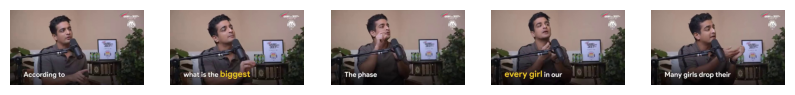

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(10, 8))

for i, ax in enumerate(axs):
    ax.imshow(Image.open(ranveer_img_paths[i]))
    ax.axis("off")

They're all images of just the interviewer, so we're ready to copy them over.

**Task 4.3.20:** Iterate over `ranveer_img_paths` in order to copy these selected images into `ranveer` directory.

In [ ]:
for image_path in ranveer_img_paths :
    shutil.copy(image_path, ranveer_dir)

print("Number of files in ranveer directory:", len(list(ranveer_dir.iterdir())))

Number of files in ranveer directory: 5


What learned

- A pre-trained MTCNN model from facenet_pytorch comes with many capabilities.
- Using the detect method on a MTCNN model returns:
- the bounding boxes of detected faces
- the probabilities that objects in bounding boxes are indeed faces
- Setting landmarks=True in the detect method on a MTCNN model also detects facial landmarks.
- Calling a MTCNN object directly with an image will return PyTorch tensors containing the detected faces.
